# Notebook 6: Neural Networks

## Introduction

In this notebook we will code a simple Neural Network from scratch.   
To truly understand Neural Nets it is useful to hand code one at least once and derive the equations. 

We will use the MNIST data set, a standard testbed for simple machine learning tasks, which is described in the wiki: https://en.wikipedia.org/wiki/MNIST_database. It comprises a training set of 60,000 handwritten images, and a test set of 10,000. Each data point consists of a 24x24 pixel image, which represents one of 10 handwritten numbers. It is often used for classification purposes, however we will apply different dimensionality and clustering methods to the data set.

A good book on neural nets is by Ian Goodfellow: http://www.deeplearningbook.org/

A nice online book giving many intuitions and deriving backprop is found in: http://neuralnetworksanddeeplearning.com/

Documentation on Keras may be found at: https://keras.io/

Finally, a visual beginner's guide to CNN's may be found at: https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/

## Guidelines

- The structure of the code is given to you and you will need to fill in the parts corresponding to each question. 
- Do not modify/erase other parts of the code if you have not been given specific instructions to do so.
- When you are asked to insert code, do so between the areas which begin:
  
  `##########################################################`
  
  `# TO_DO`
  
  `# [your code here]`
   
   And which end:
   
  `# /TO_DO
   ##########################################################`


- When you are asked to comment on the results you should give clear and comprehensible explanations. Write the comments in a 'Code Cell' with a sign `#` at the beginning of each row, and in the areas which begin:

  `# [INSERT YOUR ANSWER HERE]`

## Imports

Please do not change the cell below, you will see a number of imports. All these packages are relevant for the assignment and it is important that you get used to them. You can find more information about them in their respective documentation. As usual Numpy, Pandas, and Scikit-Learn will be used heavily.

In [1]:
#PLEASE DO NOT CHANGE THIS CELL
import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import random
%matplotlib inline

Using TensorFlow backend.


## Load Data

We will begin by loading the MNIST data set and setting a few variables such as the number of epochs which we wish to train our Neural Network for.

In [2]:
#PLEASE DO NOT CHANGE THIS CELL
num_epochs =100
num_classes = 10
batch_size= 128
learn_rate = 0.05
conv_epochs = 12
img_rows, img_cols = 28, 28

tr_loss, ts_loss, tr_acc, ts_acc = [], [], [], []

(trainX, trainY), (testX, testY) = mnist.load_data()

trainX = trainX.astype('float32')
testX =testX.astype('float32')
trainX /= 255
testX /= 255

## Visualise the Data

The cell below shows a random training image, and illustrates the shape of the data.

Training input shape:  (60000, 28, 28)
Training target shape:  (60000,)


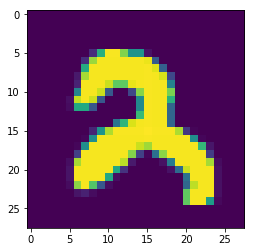

In [3]:
#PLEASE DO NOT CHANGE THIS CELL
def show_random_image():
    i = random.randint(0,trainX.shape[0])
    input_image = trainX[i]
    plt.imshow(input_image)
    
show_random_image()

print("Training input shape: ", trainX.shape)
print("Training target shape: ", trainY.shape)

__Task:__  
1) The target data `trainY` and `testY` should be one-hot-encoded. There are 10 classes.  
2) We wish to reshape the inputs (`trainX` and `testX`) to the Neural Network to be of shape (number of images, 784). For example, currently `trainX` is of shape (60000,28,28).

In [4]:
def get_one_hot(targets, nb_classes):
    ########################################################
    # TO_DO
    #[your code here]

    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

    # /TO_DO
    ########################################################

In [5]:
########################################################
# TO_DO
#[your code here]

trainX = trainX.reshape(-1,784)
testX = testX.reshape(-1,784)

trainY = get_one_hot(trainY, 10)
testY = get_one_hot(testY, 10)

# /TO_DO
########################################################

## Create Activation Functions and Their Derivatives

The expressiveness of a Neural Net comes from applying non-linear activation functions. There may be linear layers, however a function composed solely of linear layers remains linear. Why?

__Task:__      
Fill in the code to write the activation functions which we will use, as well as their derivatives.  
Remember that our inputs will be numpy arrays, not scalars.

In [6]:
def sigmoid(x):
    ########################################################
    # TO_DO
    #[your code here]

    return 1/(1 + np.exp(-x))

    # /TO_DO
    ########################################################    

    
def sigmoid_prime(x):
    ########################################################
    # TO_DO
    #[your code here]

    return sigmoid(x) * (1 - sigmoid(x))

    # /TO_DO
    ########################################################    

    
def relu(x):
    ########################################################
    # TO_DO
    #[your code here]

    return np.maximum(x, 0)

    # /TO_DO
    ########################################################    

    
def relu_prime(x):
    ########################################################
    # TO_DO
    #[your code here]

    return np.greater(x, 0).astype(int)

    # /TO_DO
    ########################################################    

    
def softmax(x):
    ########################################################
    # TO_DO
    #[your code here]

    expx = np.exp(x)
    return expx / expx.sum(axis=1, keepdims=True)

    # /TO_DO
    ########################################################    

## Create Cost Function

__Question:__   
In the cell below we have created a cost function.   
There are various cost functions that could be used. Which cost function is this one, and why is it suitable as an error for MNIST classification?

In [7]:
#PLEASE DO NOT CHANGE THIS CELL
def cost(y_truth, y_pred):
    return -((y_truth * np.log(y_pred)).sum())/y_pred.shape[0]

## Initialise Weights and Store Activations and their Derivatives

__Questions:__   
1) Why is the input weight of dimension 784?   
2) Why is the output weight of dimension 10?   
3) How many parameters will the Neural Net have in total?

In [8]:
#PLEASE DO NOT CHANGE THIS CELL
weights = [np.random.randn(*w) * 0.1 for w in [(784, 100), (100, 50), (50,10)]]
biases = [np.random.randn(*b) * 0.1 for b in [(100,), (50,), (10,)]]
activations = [(sigmoid, sigmoid_prime), (relu, relu_prime), (softmax, None)]

## A Function to Perform Forward Propogation

We wish to be able to input batches of training images and output predictions.   

__Task:__  
In the function below return a list, `a`, containing the numpy arrays which comprise the outputs from each layer of the Neural Net.   
The final layer will comprise our predictions.

To be clear, the return value from forward() should have the following shape:

Forward prop on one image: 

Layer  0  shape = (1, 784)

Layer  1  shape = (1, 100)

Layer  2  shape = (1, 50)

Layer  3  shape = (1, 10)

Forward prop on batch of 10 images: 

Layer  0  shape = (10, 784)

Layer  1  shape = (10, 100)

Layer  2  shape = (10, 50)

Layer  3  shape = (10, 10)

To be clear, the batch size doesn't change the dimensionality of the network. 

In [9]:
def forward(X, weights, biases, act):
    a = [X]
    
    for w,b,f in zip(weights, biases, act):
        ########################################################
        # TO_DO
        #[your code here]

        a.append(f[0](a[-1].dot(w) + b))
        
        # /TO_DO
        ########################################################
    return a

## Check the Dimensionality of the Return Value for the Forward Propogation Function

This should be as given above.

In [10]:
#PLEASE DO NOT CHANGE THIS CELL
print("Our list of activations has 4 elements, each a numpy array")
print("Forward prop on first image: How does dimensionality work?")
a_test1 = forward(trainX[0].reshape(-1,784),weights, biases,activations)
for i in range(len(a_test1)):
    print("Layer ",i, " shape =",a_test1[i].shape)
 
print(' ')
print("Forward prop on batch of 10 images: How does dimensionality work?")  
a_test10 = forward(trainX[0:10].reshape(-1,784),weights, biases,activations)
for i in range(len(a_test10)):
    print("Layer ",i, " shape =",a_test10[i].shape)

Our list of activations has 4 elements, each a numpy array
Forward prop on first image: How does dimensionality work?
Layer  0  shape = (1, 784)
Layer  1  shape = (1, 100)
Layer  2  shape = (1, 50)
Layer  3  shape = (1, 10)
 
Forward prop on batch of 10 images: How does dimensionality work?
Layer  0  shape = (10, 784)
Layer  1  shape = (10, 100)
Layer  2  shape = (10, 50)
Layer  3  shape = (10, 10)


## Calculate the Gradients of our Error with respect to all the Neural Network Parameters

Here we will use backpropogation.

__Task:__   
Follow the instructions in the code segment below, and complete the code.

In [11]:
def gradients(X, Y, weights, biases, act):
    # Perform a forward pass and store the return values in a variable named a:
    ########################################################
    # TO_DO
    #[your code here]

    a = forward(X, weights, biases, activations)
    
    # /TO_DO
    ########################################################

    #Inialise gradients of weights and biases
    gradients = np.empty_like(weights)
    grad_bias = np.empty_like(biases)

    #Here we perform back propogation on the output layer only
    #Be sure to understand how this works by examining the differential of the loss function
    delta = a[-1] - Y
    gradients[-1] = a[-2].T.dot(delta)
    grad_bias[-1] = np.sum(delta, axis=0)

    for i in range(len(a)-2,0,-1):
        #For each layer calculate the gradients
        #For example:
        #grad_bias[i-1] = ?
        #gradients[i-1] = ?
        ########################################################
        # TO_DO
        #[your code here]
        
        delta = act[i-1][1](a[i]) * delta.dot(weights[i].T)
        grad_bias[i-1] = np.sum(delta, axis=0)
        gradients[i-1] = a[i-1].T.dot(delta)
    
        # /TO_DO
        ########################################################

    #Divide weight gradients and biases by the batch size....why?
    
    ########################################################
    # TO_DO
    #[your code here]

    grad_bias = grad_bias / len(X)
    gradients = gradients / len(X)

    # /TO_DO
    ########################################################

    return gradients, grad_bias

## Sense Check

The code below calls your function for one image and checks the sizes of your layers:

In [12]:
#PLEASE DO NOT CHANGE THIS CELL
print("Gradients and biases - : How does dimensionality work?")
a = forward(trainX[0].reshape(-1,784),weights, biases,activations)

for i in range(len(weights)):
    grad_test1, grad_bias1 = gradients(trainX[0].reshape(-1,784), trainY[0], weights, biases, activations)
    print("Layer :", i, " Gradients, Biases - shape =", grad_test1[i].shape, grad_bias1[i].shape)  


Gradients and biases - : How does dimensionality work?
Layer : 0  Gradients, Biases - shape = (784, 100) (100,)
Layer : 1  Gradients, Biases - shape = (100, 50) (50,)
Layer : 2  Gradients, Biases - shape = (50, 10) (10,)


### The Gradients and Biases should have the Following Dimensionality:

Gradients and biases - : 
    
Layer : 0  Gradients, Biases - shape = (784, 100) (100,)
    
Layer : 1  Gradients, Biases - shape = (100, 50) (50,)
    
Layer : 2  Gradients, Biases - shape = (50, 10) (10,)

## Train the Neural Network

The outer loop will be the number of epochs we wish to perform, for each epoch we will loop in batches, thus this is mini-batch gradient descent.

__Task:__   
1) Within the inner loop calculate the gradients and biases and store in variables `gradw`, `biases`.   
2) Within the inner loop update the `weights` and `biases` using the respective gradients, and set the step size via the variable `learn_rate` defined earlier.   
3) In the outer loop create predictions on the training and test set, then store the results in variables `trpreds`, `tstpreds`.    
4) Next calculate the training and test cost, and store the results in variables `ctr`, `cst`.

We will choose the argmax of those predictions and use this to calculate our the accuracy of our predictions.


__Task:__     
Understand the code and printed outputs.    
How well would you expect the final model to perform on unseen MNIST images?

In [13]:
for i in range(num_epochs):
    for j in range(0, len(trainX), batch_size):
        X, Y = trainX[j:j+batch_size], trainY[j:j+batch_size]

        ########################################################
        # TO_DO
        #[your code here]

        #gradw, grad_bias = ?
        #biases = ?
        #weights = ?
        
        gradw, grad_bias = gradients(X, Y, weights, biases, activations)
        biases -= learn_rate * grad_bias
        weights -= learn_rate * gradw
        
        # /TO_DO
        ########################################################

        
    ########################################################
    # TO_DO
    #[your code here]
    
    #trpreds = ?
    #tstpreds = ?
    #ctr = ?
    #cst = ?
    
    trpreds = forward(trainX, weights, biases, activations)[-1]
    tstpreds = forward(testX, weights, biases, activations)[-1]
    ctr = cost(trainY, trpreds)
    cst = cost(testY, tstpreds)

    # /TO_DO
    ########################################################
    
    #we will wrap up the rest...
    tr_loss.append(ctr)
    ts_loss.append(cst)
    
    trpred_onehot = np.argmax(trpreds, axis=1)
    tstpred_onehot = np.argmax(tstpreds, axis=1)
    
    train_acc = np.mean(trpred_onehot == np.argmax(trainY, axis=1))
    test_acc = np.mean(tstpred_onehot == np.argmax(testY, axis=1))
    tr_acc.append(train_acc)
    ts_acc.append(test_acc)
    
    if i%5==0:
        print("Epoch:", i, "Tr_loss:", ctr, "Tst_loss:", cst , "Tr_acc:",train_acc, "Tst_acc:", test_acc)

Epoch: 0 Tr_loss: 0.7081493007721334 Tst_loss: 0.6912102651721126 Tr_acc: 0.7978166666666666 Tst_acc: 0.8026
Epoch: 5 Tr_loss: 0.3153556702276056 Tst_loss: 0.30608603138679347 Tr_acc: 0.9064833333333333 Tst_acc: 0.9088
Epoch: 10 Tr_loss: 0.26646836731096113 Tst_loss: 0.2612468073351167 Tr_acc: 0.92175 Tst_acc: 0.924
Epoch: 15 Tr_loss: 0.23514690553782572 Tst_loss: 0.23291588288353923 Tr_acc: 0.9312833333333334 Tst_acc: 0.9309
Epoch: 20 Tr_loss: 0.21134926734499776 Tst_loss: 0.2121359425177112 Tr_acc: 0.9384833333333333 Tst_acc: 0.9344
Epoch: 25 Tr_loss: 0.1925969213004824 Tst_loss: 0.19599472381064625 Tr_acc: 0.9433166666666667 Tst_acc: 0.9403
Epoch: 30 Tr_loss: 0.17703289986842055 Tst_loss: 0.1832668536008217 Tr_acc: 0.9477666666666666 Tst_acc: 0.9441
Epoch: 35 Tr_loss: 0.1637003752995251 Tst_loss: 0.1729125540307325 Tr_acc: 0.9520833333333333 Tst_acc: 0.9477
Epoch: 40 Tr_loss: 0.1520133858832003 Tst_loss: 0.16440606454427345 Tr_acc: 0.9552666666666667 Tst_acc: 0.9496
Epoch: 45 Tr_los

## Examine the Graph Outputs

Text(0.5, 0, 'Epoch')

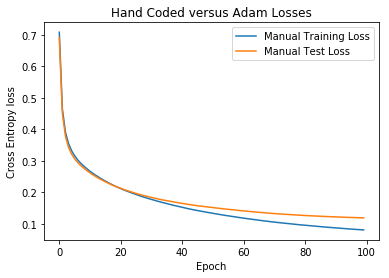

In [14]:
#PLEASE DO NOT CHANGE THIS CELL
plt.plot(tr_loss, label='Manual Training Loss')
plt.plot(ts_loss, label='Manual Test Loss')

#plt.plot(history.history['loss'], label='Keras Training Loss')
#plt.plot(history.history['val_loss'], label='Keras Test Loss')

plt.legend()
plt.title('Hand Coded versus Adam Losses')
plt.ylabel('Cross Entropy loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

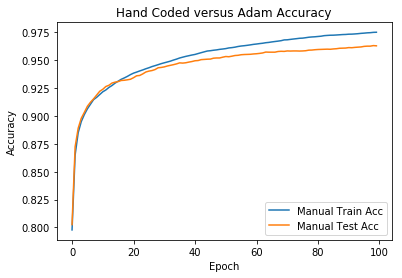

In [15]:
plt.plot(tr_acc, label='Manual Train Acc')
plt.plot(ts_acc, label='Manual Test Acc')

#plt.plot(history.history['acc'], label='Keras Train Acc')
#plt.plot(history.history['val_acc'], label='Keras Test Acc')

plt.legend()
plt.title('Hand Coded versus Adam Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

## Examine Predictions

Let's take a look at the predictions for the first 10 images in the test set.

__Task:__   
1) Check the predictions are mostly correct (this particular model has about 96% accuracy).   
2) Change the code to find images where the prediction is incorrect. Are these hard even for a human to classify or is the Neural Net making obvious errors?

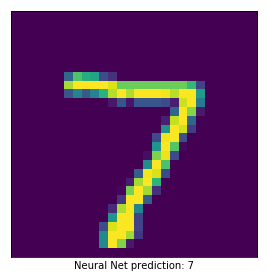

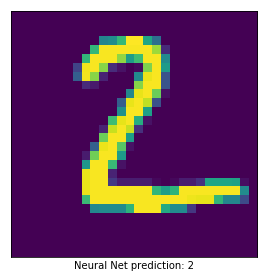

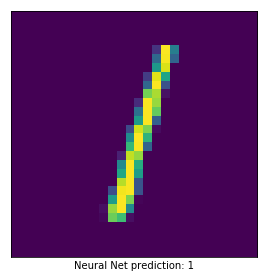

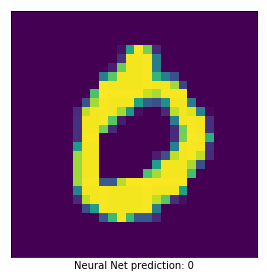

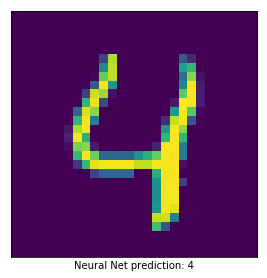

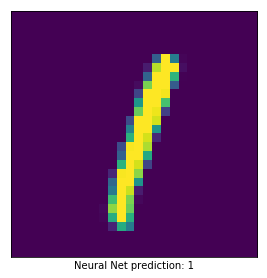

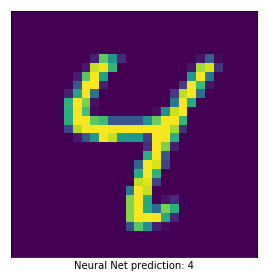

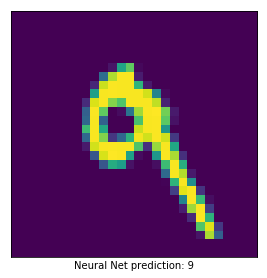

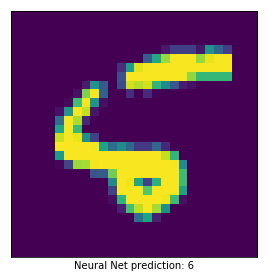

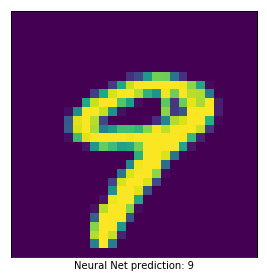

In [16]:
#PLEASE DO NOT CHANGE THIS CELL
for i in range(10):
    input_image = testX[i].reshape(1,784)
    
    tstpreds = forward(input_image, weights, biases, activations)[-1]
    
    fig            = plt.figure(i, figsize=(15, 11))
    ax = plt.subplot(1, 3, 1)
    ax.set_xticks(())
    ax.set_yticks(())
    plt.imshow(input_image.reshape(28,28))
    plt.xlabel("Neural Net prediction: " + str(np.argmax(tstpreds)))#, fontsize=18)

## Visualise Activations

Here we take the first 9 test images and show the input image together with the activations for each hidden layer. 

This is really for interest only and not easy to interpret.

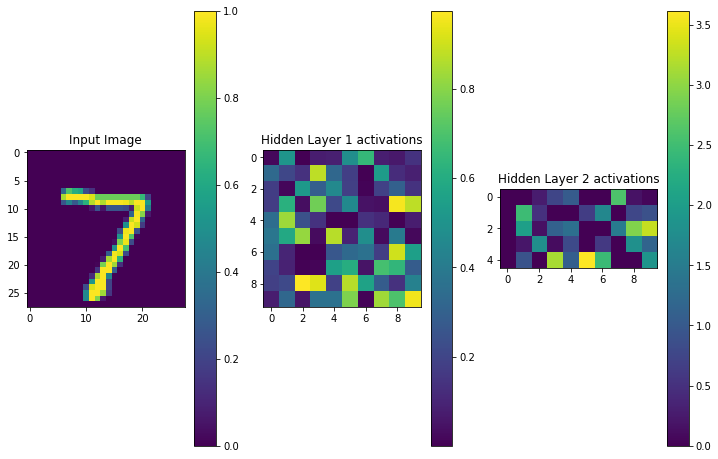

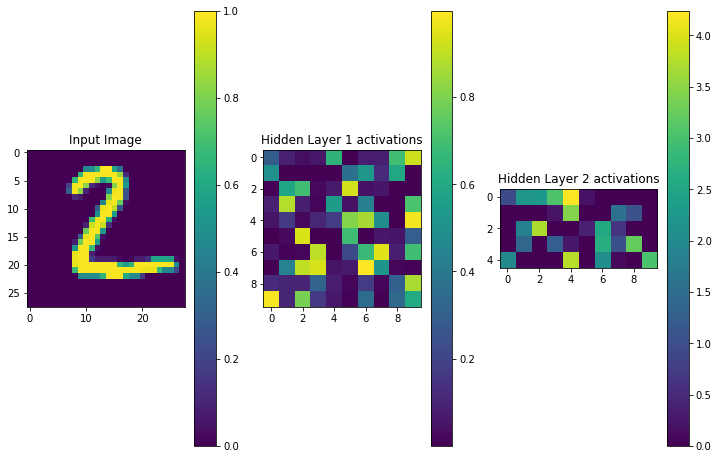

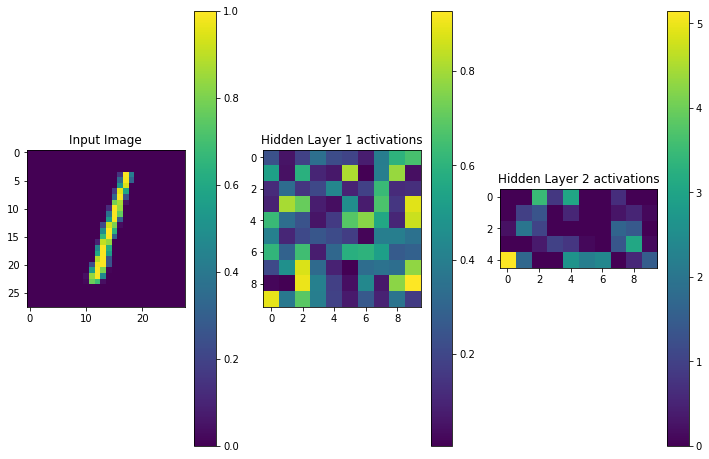

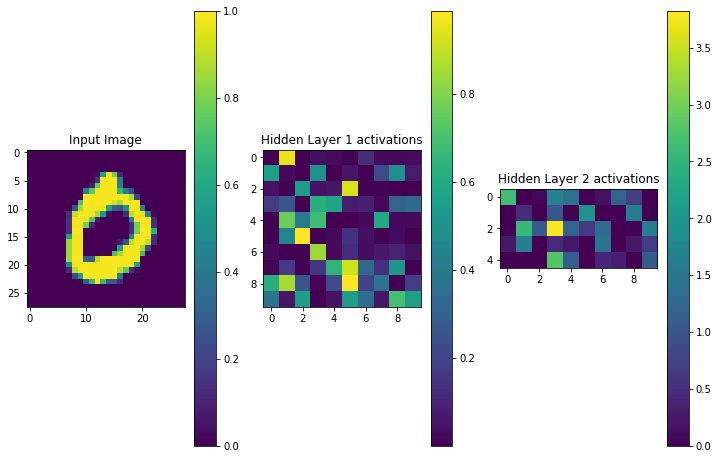

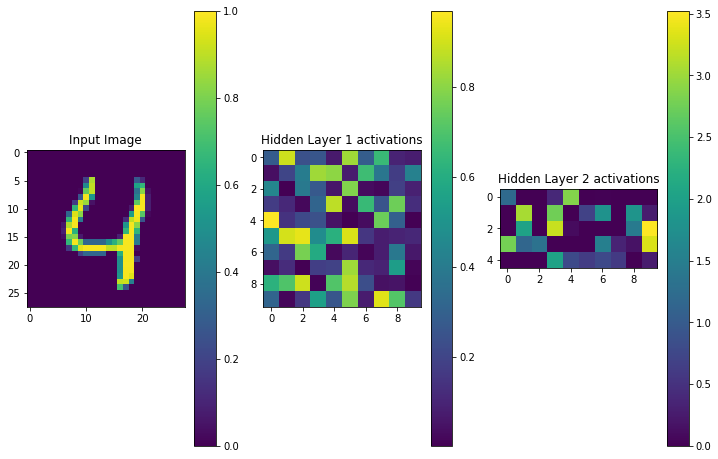

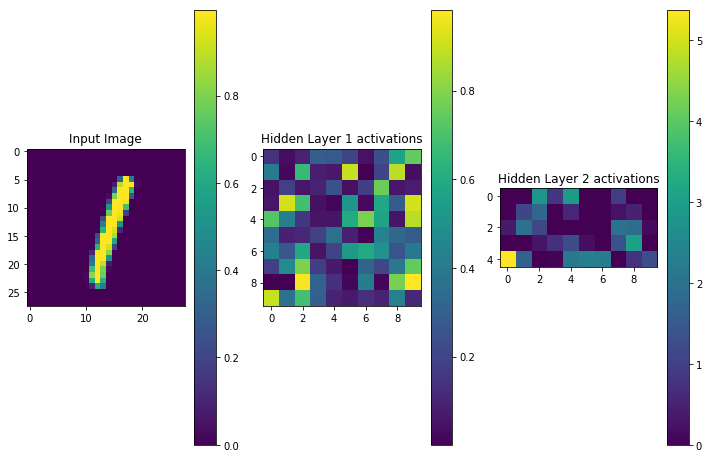

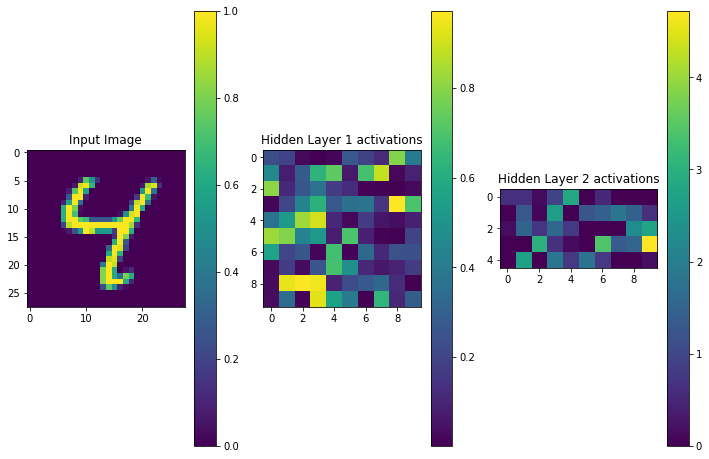

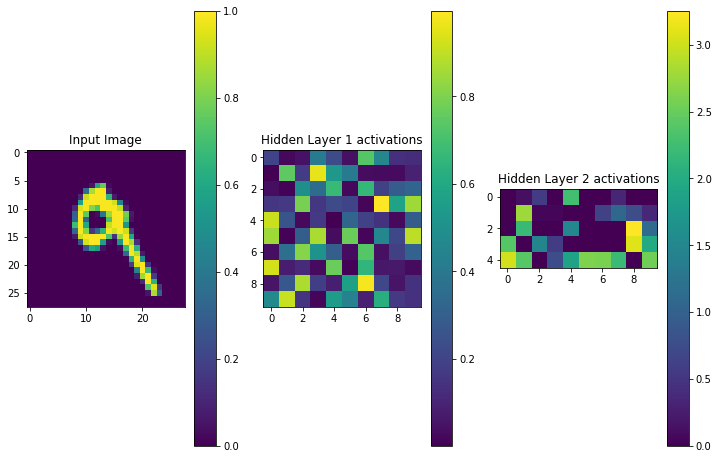

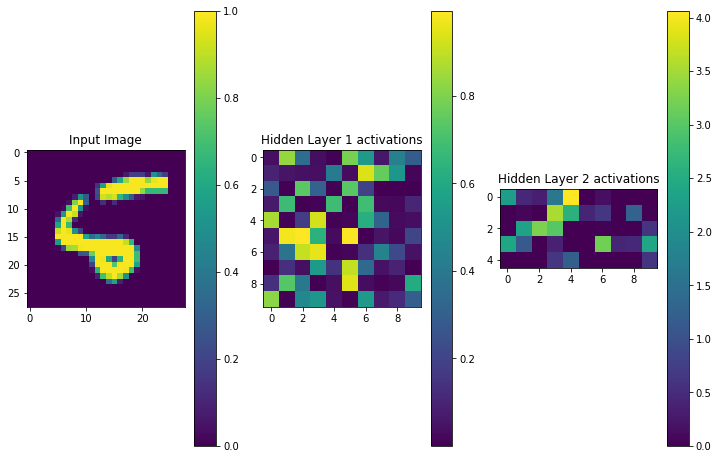

In [17]:
#PLEASE DO NOT CHANGE THIS CELL
for i in range(9):

    input_image = testX[i].reshape(1,784)
    tstpreds = forward(input_image, weights, biases, activations)

    fig = plt.figure( figsize=(12, 8))
    plt.subplot(131)
    plt.imshow(tstpreds[0].reshape(28,28))
    plt.title("Input Image")
    plt.colorbar()

    plt.subplot(132)
    plt.imshow(tstpreds[1].reshape(10,10))
    plt.title("Hidden Layer 1 activations")
    plt.colorbar()

    plt.subplot(133)
    plt.imshow(tstpreds[2].reshape(5,10))
    plt.title("Hidden Layer 2 activations")
    plt.colorbar()

## Examine Softmax Outputs

Again for the first 9 images we now examine the softmax outputs for the Neural Net.

The title shows the unseen test label and there should be high probabilities of a correct prediction for the trained model.  

However examine the final histogram.   
This has an incorrect prediction, and notice that the net was far less confident about its prediction and there were a few other competing choices.

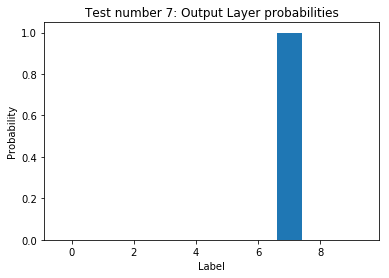

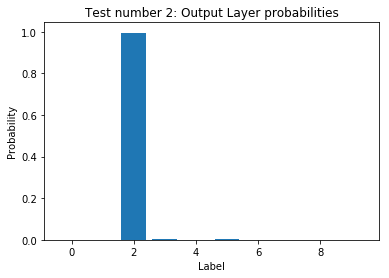

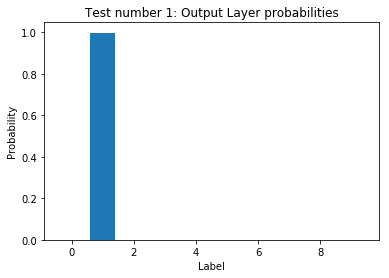

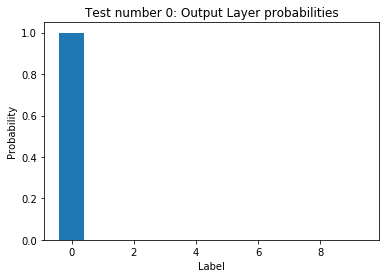

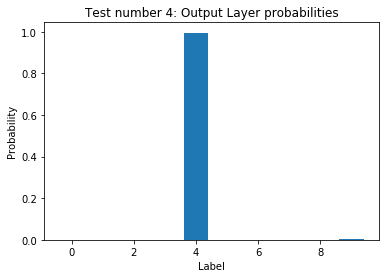

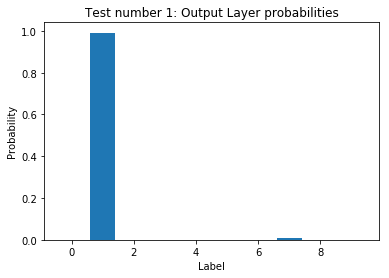

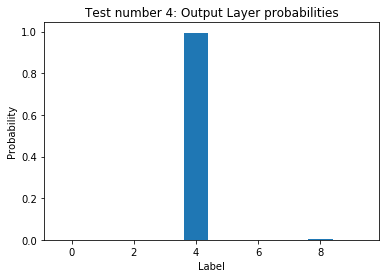

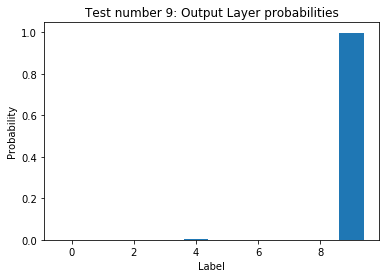

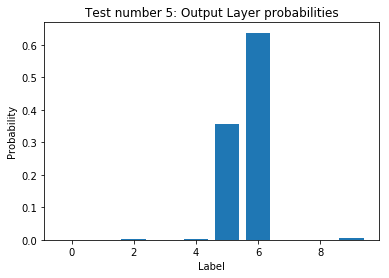

In [18]:
#PLEASE DO NOT CHANGE THIS CELL
for i in range(9):
    
    fig = plt.figure()
    input_image = testX[i].reshape(1,784)
    tstpreds = forward(input_image, weights, biases, activations)

    plt.bar(np.arange(10),list(tstpreds[-1][0])) #pred[-1]))
    plt.xlabel('Label')
    plt.ylabel('Probability')
    plt.title("Test number "+ str(np.argmax(testY[i]))+": Output Layer probabilities")